TODO:
* ~~move GRS stuff to its own class~~
  * ~~double check i'm getting concentrations at the right coordinates~~
  * ~~double check volatile normalization~~
  * ~~double check plotting~~
* ~~data downloader~~
* come up with a crater class

---
# 0. Setup

## Add path to source

In [1]:
## This is OD way to deal with paths

def getPath(*args):
    """Join all arguments into a single path. Use 'current' as a stand in for path to current file."""
    import os
    args = [os.getcwd() if arg == 'current' else arg for arg in args]
    return os.path.abspath(os.path.join(*args))

    
def path_addSrc(fullpath_src = None, relpath_src = None, parent = False, verbose = False):
    """
    Add directory "src/" to path.
        
    PARAMETERS:
        fullpath_src : string
            Path to source from root.
        relpath_src : string
            Path to source from directory of current file.
        parent : boolean
            Use parent folder as source
        verbose : boolean
            Prints source directory path.
    
    RETURN:
        path_src : string
            Path to source from root.
    """
    
    import sys
    import os

    if fullpath_src:
        path_src = getPath(fullpath_src)
    elif relpath_src:
        path_src = getPath('current', relpath_src)
    elif parent:
        path_src = getPath('current', '..')
        
    if verbose: print("Path to source: " + path_src)
    
    sys.path.append(path_src)
    return path_src


path_src = path_addSrc(parent=True, verbose=True)

Path to source: D:\sync\01_Research\Mars_Magnetics\code\05_mag_src_map\src


## Download data

In [2]:
from lib.DataDownloader import DataDownloader as dd

dd.download_folder(path_src=path_src, url="https://drive.google.com/drive/u/0/folders/1D8oWu05X83Xa8dKB1C_SUutBNvbJUt4n", overwrite=False)

The provided `path_src` parameter doesn't contain "home". On Linux systems, this means you might be deleting important directories. If you proceed, `path_src/data/` will be deleted. Make sure you have provided the correct path. 
Would you like to proceed? [y/n]  y



Data folder contents: 
	craters
	crustal_heat_flow
	crustal_thickness
	GRS
	README.txt


## Import

In [3]:
import numpy as np
# import scipy.optimize as sy
import matplotlib.pyplot as plt
# from numba import jit
import math


from lib.GRS import GRS as GRSClass

GRS = GRSClass(getPath(path_src, "data/GRS/"))
GRS.loadData()

---
# 1. Analysis

In [4]:
Lyot = {
    "lon": 29.32,
    "lat": 50.47,
    "formation": 3.4e9,
    "diameter_km": 220.31,
}
Henry = {
    "lon": 23.4,
    "lat": 10.8,
    "formation": 3.6e9,
    "diameter_km": 167.58,
}
Newton = {
    "lon": -158.07,
    "lat": -40.44,
    "formation": 4.11e9,
    "diameter_km": 312.43,
}

---
### checking the new crustal thickness class!! :)

In [5]:
from lib.Crust import Crust as CrustClass

Crust = CrustClass()
Crust.loadData(path_src, 0.1)
Crust.getThickness(0,0)

39.783

---
### Heat Analysis Codes

In [6]:
"""
Heat analysis codes
"""

HPE = {
    # Constants from:
    #     - "Amagmantic Hydrothermal Systems on Mars from Radiogenic Heat", by Ojha et al. 2021,
    #     - "Geodynamics", by Turcotte & Schubert 2014.
    "U238": {
        "isotopic_frac": 0.9928, # natural abundance of this isotope relative to all isotopes of this element
        "heat_release_const": 9.46e-5, # net energy per unit mass [W/kg]
        "half_life": 4.47e9
    },
    "U235": {
        "isotopic_frac": 0.0071,
        "heat_release_const": 5.69e-4,
        "half_life": 7.04e8
    },
    "Th232": {
        "isotopic_frac": 1.00,
        "heat_release_const": 2.64e-5,
        "half_life": 1.40e10
    },
    "K40": {
        "isotopic_frac": 1.191e-4,
        "heat_release_const": 2.92e-5,
        "half_life": 1.25e9
    }
}


def calc_H(thisGRS, lon, lat, t, volatile_adjusted=True):
    """
    Calculate heat production rate in lithosphere [W/kg?] at a specific coordinate/time due to decay of radiogenic heat producing elements (U238, U235, Th232, K40).
    
    PARAMETERS:
        thisGRS : GRS type object
            Contains elemental abundances from GRS orbiter.
        lon, lat : float
            Coordinates at which to calculate H. These are used to find GRS data.
        time : float
            How many years in the past to calculate H. These are used to calculate elapsed half-lives of radiogenic HPEs.
            Ex: `t=3.4e9` would specify 3.4 billion years in the past.
        volatile_adjusted : bool
            Determine whether or not to normalize GRS radiogenic HPE concentrations to a volatile-free basis. See the next method "getAdjustedConcentration" in the GRS.py class for details.

    RETURN:
        H : float
            Heat production rate in lithosphere [W/kg?] at a specific coordinate/time due to decay of radiogenic heat producing elements (U238, U235, Th232, K40).
            
    METHODOLOGIES:
        - Hahn et al 2011: Martian surface production and crustal heat flow from Mars Odyssey Gamma-Ray spectrometry
        - Turcotte and Schubert 2001: Geodynamics (textbook)    
    """

    
    thisHPE = HPE
    
    # get concentrations of each element (these coordinates, current day)
    for element in thisHPE:
        elementname = ''.join([char for char in element if not char.isdigit()]).lower()
        if elementname == 'u':
            concentration = thisGRS.getConcentration(lon, lat, "th", volatile_adjusted) / 3.8
        else:
            concentration = thisGRS.getConcentration(lon, lat, elementname, volatile_adjusted)
    
    
        if concentration == thisGRS.getNanVal():
            return thisGRS.getNanVal()
        thisHPE[element]["concentration"] = concentration
    
    # calculate crustal heat production (these coordinates, `t` years ago)
    H = 0
    for element in thisHPE:
        H += (
            thisHPE[element]["isotopic_frac"] 
            * thisHPE[element]["concentration"] 
            * thisHPE[element]["heat_release_const"] 
            * math.exp((t * math.log(2))/(thisHPE[element]["half_life"]))
        )
    return H
            
    

def calc_CurieDepths(thisGRS, thisCrust, lon, lat, t, q_b_mW, curie_temps, volatile_adjusted=True):
    """
    Calculate curie depths [km] at a specific coordinate/time due to decay of radiogenic heat producing elements (U238, U235, Th232, K40). Assume surface temperature is 0 Celsius.
    
    PARAMETERS:
        thisGRS : GRS type object
            Contains elemental abundances from GRS orbiter.
        lon, lat : float
            Coordinates at which to calculate H. These are used to find GRS data.
        time : float
            How many years in the past to calculate H. These are used to calculate elapsed half-lives of radiogenic HPEs.
                - Ex: `t=3.4e9` would specify 3.4 billion years in the past.
        q_b_mW : float
            Heat flow [mW m^-2] from the lower mantle into the base of the lithosphere. Presently varies between 1.3 and 13.5, average of 7. On ancient Mars, this could have been anything from 20 to 60.
        curie_temps : 1D float array
            The purpose of this function is to find the depth at which the ambient temperature [degrees Celsius!!!] reaches these temperatures.
                - Ex: `curie_temps=(320,580,670)` would correspond to single domain pyrrhotite, single domain magnetite, and multidomain hematite respectively (Artemieva et al., 2005).
        volatile_adjusted : bool
            Determine whether or not to normalize GRS radiogenic HPE concentrations to a volatile-free basis. See the next method "getAdjustedConcentration" in the GRS.py class for details.

    RETURN:
        curie_depths : 1D float array
            Return the depth below the surface at which temperature due to HPE decay reaches the curie points specified as input. 
            The input `curie_temps` will correspond element-wise with the output `curie_depths`, i.e. we ensure len(curie_temps) == len(curie_depths).
            
    METHODOLOGIES:
        - Hahn et al 2011: Martian surface production and crustal heat flow from Mars Odyssey Gamma-Ray spectrometry
        - Turcotte and Schubert 2001: Geodynamics (textbook)    
    """
    
    # curie_temps = (320,580,670)
    
    H = calc_H(thisGRS, lon, lat, t, volatile_adjusted) # heat production in crust [W kg^-1]    

    if H == thisGRS.getNanVal():
        return (GRS.getNanVal(),)*len(curie_temps)

    rho = thisCrust.getDensity() # density of crust [kg m^-3]

    # thickness_crust_m = 40e3 # from random map i found online -- eventually automate this!
    thickness_crust_m = thisCrust.getThickness(lon, lat) * 1000
    
    
    
    
    k_cr = 2.5 # thermal conductivity of crust [W m^-1 K^-1]
    k_m = 4 # thermal conductivity of mantle [W m^-1 K^-1]
    q_b = q_b_mW * 10**-3 # basal heat flow, parameter sweep this from 0-50
    
    def calc_T(depth_km):
        """
        From supplemental text 3 of "Depletion of Heat Producting Elements in the Martian Mantle" by Ojha et al. 2019
        """
        depth_m = depth_km*1000
        if depth_m <= thickness_crust_m:
            T = ((rho * H * depth_m)/(k_cr))*(thickness_crust_m - depth_m/2) + (q_b * depth_m)/(k_cr)
        else:
            left = ((rho * H * thickness_crust_m)/(k_cr))*(thickness_crust_m - thickness_crust_m/2) + (q_b * thickness_crust_m)/(k_cr)
            right = ((rho * H * thickness_crust_m**2)/(2*k_m)) + ((q_b * thickness_crust_m)/(k_m))
            T_0 = left-right

            T = T_0 + ((rho * H * thickness_crust_m**2)/(2*k_m)) + ((q_b * depth_m)/(k_m))
        return T
    
    
    ## ensure curie_depths is iterable
    if type(curie_temps) is not list and type(curie_temps) is not tuple:
        curie_temps = (curie_temps,)
    
    
    
    curie_depths = []
    error = 0.01
    
    for curie_temp in curie_temps:
        depth_left = 0
        depth_right = 500
        depth_mid = (depth_right+depth_left)/2

        temp_left = calc_T(depth_left)
        temp_right = calc_T(depth_right)
        temp_mid = calc_T(depth_mid)

        assert temp_left < curie_temp and curie_temp < temp_right, 'erm what the fish'
        
        while abs( temp_mid - curie_temp ) > error:
            if temp_mid < curie_temp:
                depth_left = depth_mid
                temp_left = temp_mid
            else:
                depth_right = depth_mid
                temp_right = temp_mid                
            depth_mid = (depth_right+depth_left)/2
            temp_mid = calc_T(depth_mid)
        
        curie_depths.append(depth_mid)
        
        
    return curie_depths
            
    
# thiscrater = Lyot

# # import time
# # start_time = time.time()
# # for i in range(360*180):
# #     x = calc_CurieDepths(GRS, thiscrater['lon'], thiscrater['lat'], thiscrater['formation'], 15, volatile_adjusted=True)
# # s = time.time() - start_time
# # print(s)

# import timeit
# timeit.timeit(lambda: calc_CurieDepths(GRS, thiscrater['lon'], thiscrater['lat'], thiscrater['formation'], 15, volatile_adjusted=True), number = 10000)

calc_CurieDepths(GRS, Crust, 0, 0, t=4e9, q_b_mW=30, curie_temps=(580,), volatile_adjusted=True)

[30.61676025390625]

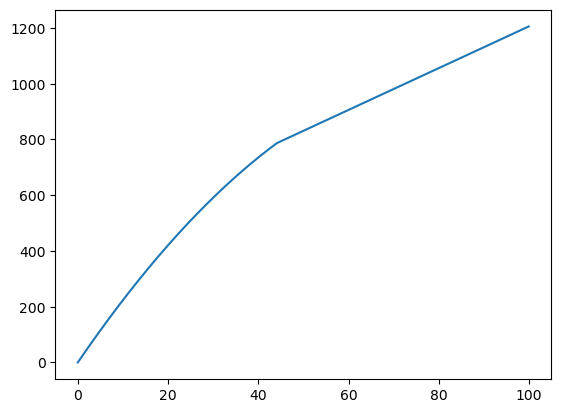

In [7]:
"""
Make a temperature vs depth profile of the lithosphere for a crater

(verify plotting works with this rewritten code)
"""

def calc_TempDepthProfile(thisGRS, thisCrust, lon, lat, t, depths_km, q_b_mW, volatile_adjusted=True):
    

    H = calc_H(thisGRS, lon, lat, t, volatile_adjusted) # heat production in crust [W kg^-1]    

    # i address nanvals later on to make sure it's an arraylike :)
    # if H == thisGRS.getNanVal():
    #     return thisGRS.getNanVal()

    rho = thisCrust.getDensity() # density of crust [kg m^-3]

    # thickness_crust_m = 40e3 # from random map i found online -- eventually automate this!
    thickness_crust_m = thisCrust.getThickness(lon, lat) * 1000
    
    
    k_cr = 2.5 # thermal conductivity of crust [W m^-1 K^-1]
    k_m = 4 # thermal conductivity of mantle [W m^-1 K^-1]
    q_b = q_b_mW * 10**-3 # basal heat flow, parameter sweep this from 0-50
    
    
    def calc_T(depth_km):
        depth_m = depth_km*1000
        if depth_m <= thickness_crust_m:
            T = ((rho * H * depth_m)/(k_cr))*(thickness_crust_m - depth_m/2) + (q_b * depth_m)/(k_cr)
        else:
            left = ((rho * H * thickness_crust_m)/(k_cr))*(thickness_crust_m - thickness_crust_m/2) + (q_b * thickness_crust_m)/(k_cr)
            right = ((rho * H * thickness_crust_m**2)/(2*k_m)) + ((q_b * thickness_crust_m)/(k_m))
            T_0 = left-right

            T = T_0 + ((rho * H * thickness_crust_m**2)/(2*k_m)) + ((q_b * depth_m)/(k_m))
        return T
            
            
    # depths_km = np.arange(0, 100, 0.1)
    
    if H == thisGRS.getNanVal():
        temps_C = [thisGRS.getNanVal() for d in depths_km]
    else:
        temps_C = [calc_T(d) for d in depths_km]
    
    # vfunc_calc_T = np.vectorize(calc_T)
    # temps_C = vfunc_calc_T(depths_m)
        
    return temps_C







thiscrater = Henry

depths_km = np.arange(0, 100, 0.1)
temps_C = calc_TempDepthProfile(GRS, Crust, thiscrater['lon'], thiscrater['lat'], thiscrater['formation'], depths_km, 30)

# test nanvals (silicon is undefined at these coords
# depths_km, temps_C = calc_TempDepthProfile(GRS, 0, 55, thiscrater['formation'], 15)


plt.plot(depths_km, temps_C)

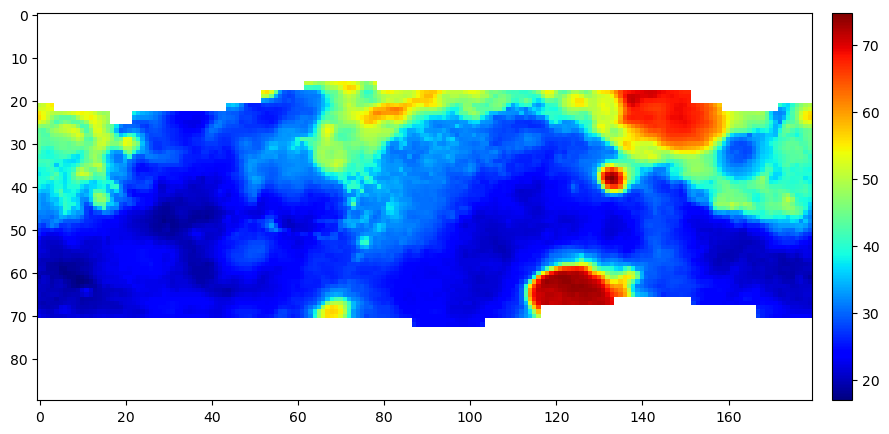

In [8]:
"""
Plot curie depths for 580 km globally
"""

dat = []
curie_temps = (580,)

for lat in np.arange(-90,90,2):
    newline = []
    for lon in np.arange(-180,180,2):
        x = calc_CurieDepths(GRS, Crust, lon, lat, t=4e9, q_b_mW=30, curie_temps=curie_temps, volatile_adjusted=True)
        newline.append(x)
    dat.append(newline)

# plt.imshow(test[::-1], cmap="jet")
# plt.colorbar()
dat = np.asarray(dat)
dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

fig = plt.figure(figsize=(10,7))
ax = plt.axes()
im = ax.imshow(dat[::-1], cmap="jet")

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

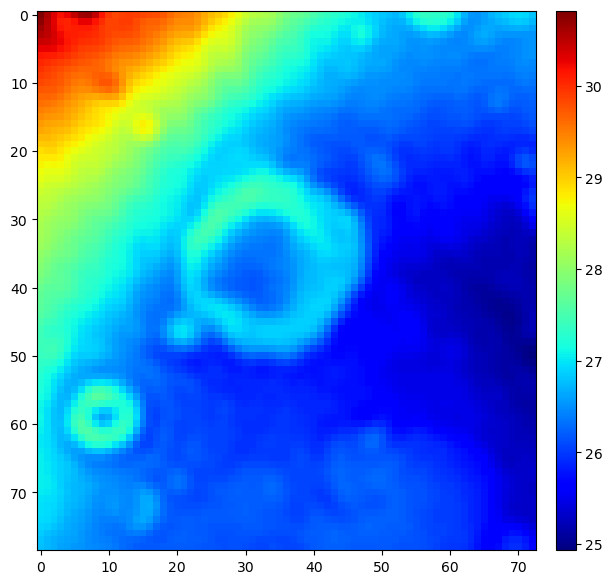

In [9]:
"""
Plot curie depths for 580 km henry
"""

dat = []
curie_temps = (580,)

for lat in np.arange(6.65,14.5,0.1):
    newline = []
    for lon in np.arange(20,27.3,0.1):
        x = calc_CurieDepths(GRS, Crust, lon, lat, t=4e9, q_b_mW=30, curie_temps=curie_temps, volatile_adjusted=True)
        newline.append(x)
    dat.append(newline)

# plt.imshow(test[::-1], cmap="jet")
# plt.colorbar()
dat = np.asarray(dat)
dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

fig = plt.figure(figsize=(10,7))
ax = plt.axes()
im = ax.imshow(dat[::-1], cmap="jet")
    
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

---
### henry meta crater yipe

In [10]:
def calc_P(diameter_km, r_km, z_km):
    
    ## unit conversions
    diameter_m = diameter_km * 1000
    r_m = r_km * 1000 # horizontal distance from impact site
    z_m = z_km * 1000 # depth from floor of crater (?)
    
    
    ## start complicated math shit -- NOTE THAT EVERYTHING IS IN SI, I.E. METERS NOT KILOMETERS!!!
    
    diam_obs = diameter_m # observed crater diameter
    diam_star = 7 * 1000 # transition diameter from simple to complex crater, assumed 7km for mars
    diam_trans = 0.7576 * (diam_obs ** 0.921) * (diam_star ** 0.079)
    # print(diam_trans / 1000)
    
    v_proj = 10 * 1000 # impact velocity, varies from 8-12 km/s, assumed 10 km/s
    g = 3.721 # surface gravity
    E = ((diam_trans * v_proj**0.09 * g**0.22)/(0.2212)) ** (1/0.26) # energy of impactor
    
    rho = 2900 # density of impactor, assumed 2900 kg/m^3 for basaltic
    r_proj = ((3 * E)/(2 * math.pi * rho * v_proj**2))**(1/3) # radius of impactor, assumed to be spherical basaltic projectile
    
    R_0 = 0.75 * r_proj # radius of isobaric core, ~70% of projectile radius
    
    C_basalt = 3.5 * 1000 # bulk speed of sound in material, assumed 3.5 km/s for kinosaki basalt
    S_basalt = 1.5 # shock parameter of material, assumed 1.5 for kinosaki basalt
    
    P_0 = 0.25 * rho * v_proj * (2*C_basalt + S_basalt*v_proj) # isobaric pressure (within isobaric core)
    
    R_direct = math.sqrt( (z_m - R_0)**2 + r_m**2 ) # distance travelled by direct pressure waves
    R_reflect = math.sqrt( (z_m + R_0)**2 + r_m**2 ) # distance travelled by reflected pressure waves
    
    tau = (R_reflect - R_direct) / C_basalt # time delay between arrival of initial and reflected pressure waves
    tau_rise = r_proj / v_proj # time rise (?)
    
    def naive_P(this_r):
        if (this_r <= R_0):
            P = P_0
        else:        
            n = 1.87 # exponential decay constant, assumed invariant with distance from impact
            # P = P_0 * ((this_r / R_0) ** -n) # for some reason this blows up ????? so i use the shahnas equation instead lol
            P = rho * (0.5*v_proj) * (C_basalt + S_basalt * (0.5*v_proj) * (R_0/this_r)**n ) * (R_0/this_r)**n
        return P
    
    if (tau > tau_rise):
        P_eff = naive_P(R_direct)
    else: # reduced peak pressure due to interference of waves
        P_eff = naive_P(R_direct) - naive_P(R_reflect) * (1 - (tau / tau_rise)) 
        
    P_eff = P_eff * 1e-9 # adjust to units of gigapascals

    return P_eff



###################################
# # calc_P(henry["diameter_km"], 10, 10)

# pressures = []
# for depth in range(71):
#     newline = []
#     for distance in range(71):
#         newline.append(calc_P(thiscrater["diameter_km"], distance, depth))
#     pressures.append(newline)

        
# fig1 = plt.figure(figsize=(7,5))
# ax1 = plt.axes()
# im1 = ax1.imshow(pressures, cmap="jet")
# cax1 = fig1.add_axes([ax1.get_position().x1+0.02,ax1.get_position().y0,0.02,ax1.get_position().height])
# cbar1 = plt.colorbar(im1, cax=cax1)

# ax1.set_title("Shockwave Pressures at Lyot Impact\n")
# # plt.text(x=0.45, y=0.95, s="Shockwave Pressures at Newton Impact", fontsize=14, ha="center", transform=fig.transFigure)
# # plt.text(x=0.45, y=0.90, s= "Coordinates = (-158.07, -40.44); Diam = 312.43 km; Age = 4.11 Ga", fontsize=10, color='grey', ha="center", transform=fig.transFigure)
# # plt.subplots_adjust(top=0.85, wspace=0.3)
# ax1.set_xlabel("Radius (km)")
# ax1.set_ylabel("Depth (km)")
# cbar1.set_label(r'Pressure (GPa)', y=0.7)


# threshold = 2
# demag = [[1 if point > threshold else 0 for point in line] for line in pressures]


# fig2 = plt.figure(figsize=(7,5))
# ax2 = plt.axes()
# im2 = ax2.imshow(demag, cmap="jet")
# cax2 = fig2.add_axes([ax2.get_position().x1+0.02,ax2.get_position().y0,0.02,ax2.get_position().height])
# plt.colorbar(im2, cax=cax2)

# ax2.set_title("Shock Demagnetization Extent at Lyot Impact\n")
# # plt.text(x=0.45, y=0.95, s="Shock Demagnetization Extent at Newton Impact", fontsize=14, ha="center", transform=fig.transFigure)
# # plt.text(x=0.45, y=0.90, s= "Coordinates = (-158.07, -40.44); Diam = 312.43 km; Age = 4.11 Ga", fontsize=10, color='grey', ha="center", transform=fig.transFigure)
# ax2.set_xlabel("Radius (km)")
# ax2.set_ylabel("Depth (km)")





# # print(calc_P(henry["diameter_km"], 30, 30))

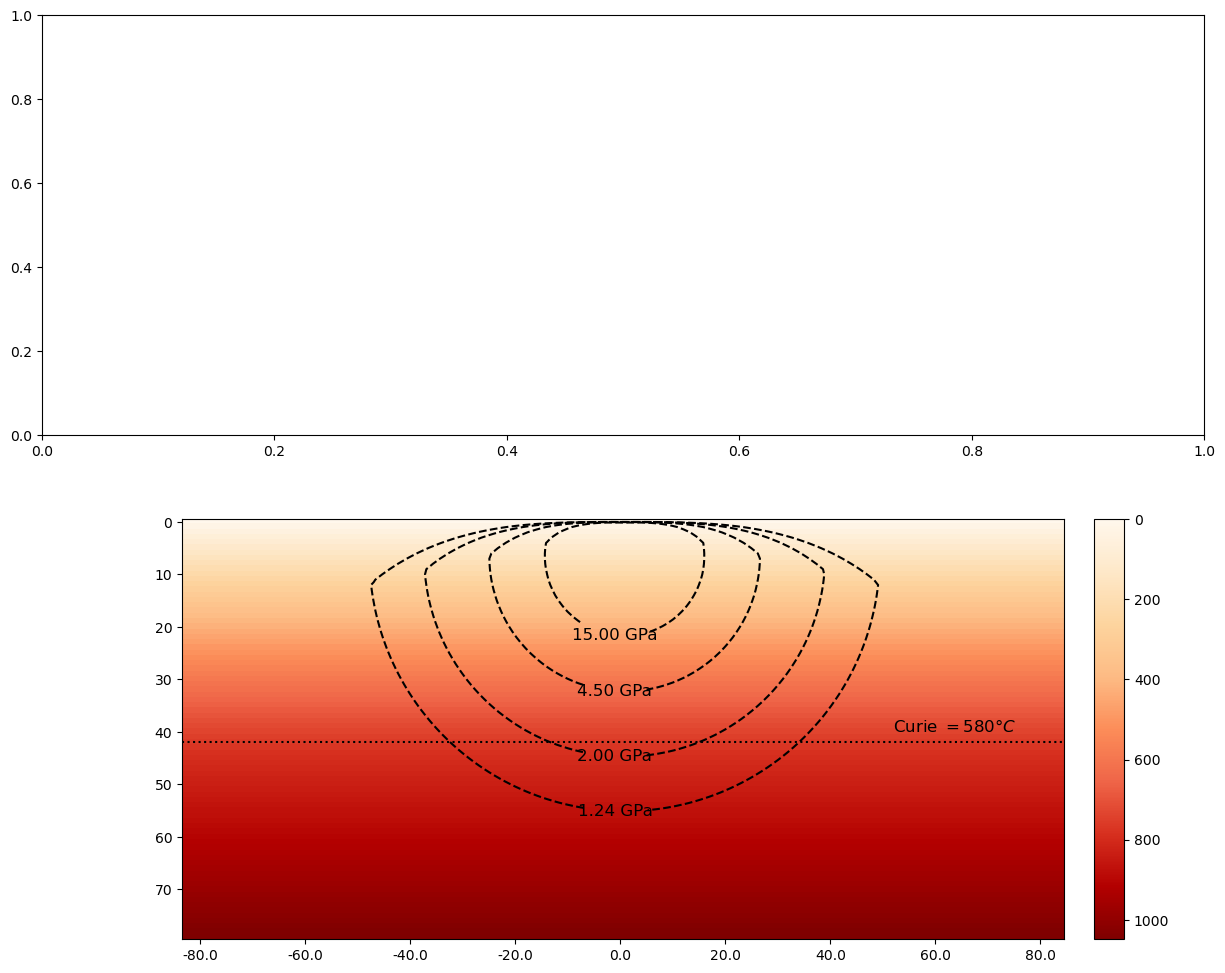

In [11]:
thicrater = Henry

depths_km = np.arange(0, 80, 1)
radii_km = np.arange(thiscrater['diameter_km'] * (-1/2), thiscrater['diameter_km'] * (1/2), 1)


temps_C = calc_TempDepthProfile(GRS, Crust, thiscrater['lon'], thiscrater['lat'], thiscrater['formation'], depths_km, 30)



Pdat = []
Tdat = []
for i, depth in enumerate(depths_km):
    Pline = []
    Tline = []
    for j, radius in enumerate(radii_km):
        Pline.append(calc_P(thiscrater["diameter_km"], radius, depth))
        Tline.append(temps_C[i])
    Pdat.append(Pline)
    Tdat.append(Tline)

fig, axs = plt.subplots(nrows=2,figsize=(15,12))

ax = axs[1]

# labels = [1.24, 2, 4.5, 15]
# locs = [(55,55),(65,38),(70,30),(75,20)]
labels = [1.24, 2, 4.5, 15]
locs = [(82,60),(82,42),(82,30),(82,20)]
Pcont = ax.contour(Pdat, labels, linestyles='dashed', colors='k')
tab = ax.clabel(Pcont, Pcont.levels, inline=True, fontsize=12, manual=locs, fmt='%.2f GPa')
for t in tab:
    # t.set_rotation(-25)
    t.set_rotation(0)


Tim = ax.imshow(Tdat, cmap='OrRd')
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(Tim, cax=cax)
cbar.ax.invert_yaxis()


# ax.axhline(y=44, linestyle='dotted', color='k')
# ax.text(135,42,'Curie $= 580 \degree C$',fontsize=12)
ax.axhline(y=42,linestyle='dotted', color='k')
ax.text(135,40,'Curie $= 580 \degree C$',fontsize=12)

# ax.set_xticks(radii_km)
t1 = ax.get_xticks()
t1 += 3
t2 = np.linspace(-100,100,t1.shape[0])
ax.set_xticks(t1[1:-1], t2[1:-1])
plt.show()



#################

ax2 = axs[0]



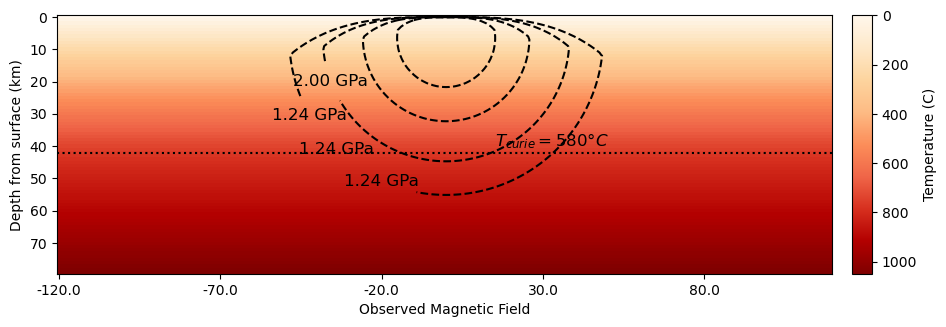

In [103]:
thicrater = Henry

depths_km = np.arange(0, 80, 1)
radii_km = np.arange(-120,120,1)


temps_C = calc_TempDepthProfile(GRS, Crust, thiscrater['lon'], thiscrater['lat'], thiscrater['formation'], depths_km, 30)



Pdat = []
Tdat = []
for i, depth in enumerate(depths_km):
    Pline = []
    Tline = []
    for j, radius in enumerate(radii_km):
        Pline.append(calc_P(thiscrater["diameter_km"], radius, depth))
        Tline.append(temps_C[i])
    Pdat.append(Pline)
    Tdat.append(Tline)

fig, ax = plt.subplots(figsize=(10,7))


labels = [1.24, 2, 4.5, 15]
locs = [(82,60),(82,42),(82,30),(82,20)]
Pcont = ax.contour(Pdat, labels, linestyles='dashed', colors='k')
tab = ax.clabel(Pcont, Pcont.levels, inline=True, fontsize=12, manual=locs, fmt='%.2f GPa')
for t in tab:
    t.set_rotation(0)


Tim = ax.imshow(Tdat, cmap='OrRd')
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(Tim, cax=cax)
cbar.ax.invert_yaxis()


ax.axhline(y=42,linestyle='dotted', color='k')
ax.text(135,40,'$T_{\t{curie}}= 580 \degree C$',fontsize=12)


ax.set_ylabel('Depth from surface (km)')
ax.set_xlabel('Observed Magnetic Field')
cbar.set_label('Temperature (C)',y=0.5)

# # ax.set_xticks(radii_km)
t1 = ax.get_xticks()
t2 = t1 - 120
# t2 = np.linspace(-100,100,t1.shape[0])
ax.set_xticks(t1[1:-1],t2[1:-1])
# plt.show()

In [13]:
# plt.imshow(Tdat, cmap='Reds')
# plt.imshow(Tdat, cmap='autumn_r')
# plt.contour(Pdat, [0.5,1,1.5,2,2.5,5,10,50,100], linestyles='dotted')
    
        
# fig1 = plt.figure(figsize=(7,5))
# ax1 = plt.axes()
# im1 = ax1.imshow(pressures, cmap="jet")
# cax1 = fig1.add_axes([ax1.get_position().x1+0.02,ax1.get_position().y0,0.02,ax1.get_position().height])
# cbar1 = plt.colorbar(im1, cax=cax1)

# ax1.set_title("Shockwave Pressures at Lyot Impact\n")
# ax1.set_xlabel("Radius (km)")
# ax1.set_ylabel("Depth (km)")
# cbar1.set_label(r'Pressure (GPa)', y=0.7)


# threshold = 2
# demag = [[1 if point > threshold else 0 for point in line] for line in pressures]


# fig2 = plt.figure(figsize=(7,5))
# ax2 = plt.axes()
# im2 = ax2.imshow(demag, cmap="jet")
# cax2 = fig2.add_axes([ax2.get_position().x1+0.02,ax2.get_position().y0,0.02,ax2.get_position().height])
# plt.colorbar(im2, cax=cax2)

# ax2.set_title("Shock Demagnetization Extent at Lyot Impact\n")
# # plt.text(x=0.45, y=0.95, s="Shock Demagnetization Extent at Newton Impact", fontsize=14, ha="center", transform=fig.transFigure)
# # plt.text(x=0.45, y=0.90, s= "Coordinates = (-158.07, -40.44); Diam = 312.43 km; Age = 4.11 Ga", fontsize=10, color='grey', ha="center", transform=fig.transFigure)
# ax2.set_xlabel("Radius (km)")
# ax2.set_ylabel("Depth (km)")

---
### plotting maven tracks

In [14]:
# format:
# dat.X; dat.Y; dat.Blon; dat.Bcola; dat.Br; dat.Bmag; dat.Bmag_norm
fn = getPath(path_src,'data','mvn_mag','mvn_henry.dat')
dat = np.loadtxt(fn, delimiter=',')

jumps = [0]
for i in range(dat.shape[0]-1):
    if abs(dat[i,1]-dat[i+1,1]) > 0.1:
        jumps.append(i+1)

In [15]:
tracks = []
for i in range(len(jumps)-1):
    track = dat[jumps[i]:jumps[i+1]]
    
    # lat check
    inlat = np.any(10 < track[:,1]) and np.any(track[:,1] < 12.1)
    inlon = np.any(23.7 < track[:,0]) and np.any(track[:,0] < 24.6)
    
    if inlat and inlon:
        tracks.append(track)
        
print(len(tracks))

8


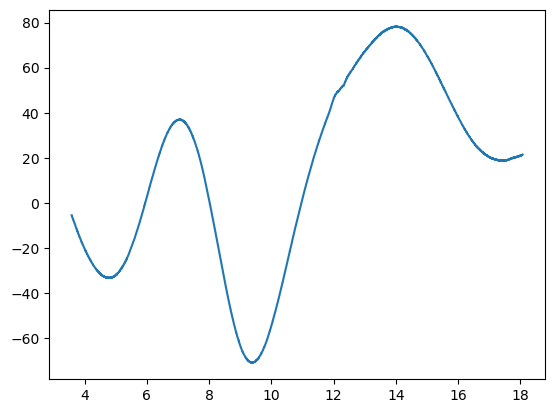

In [69]:
i=5
plt.plot(tracks[i][:,1], tracks[i][:,4])

bmag = tracks[2]
br = tracks[5]

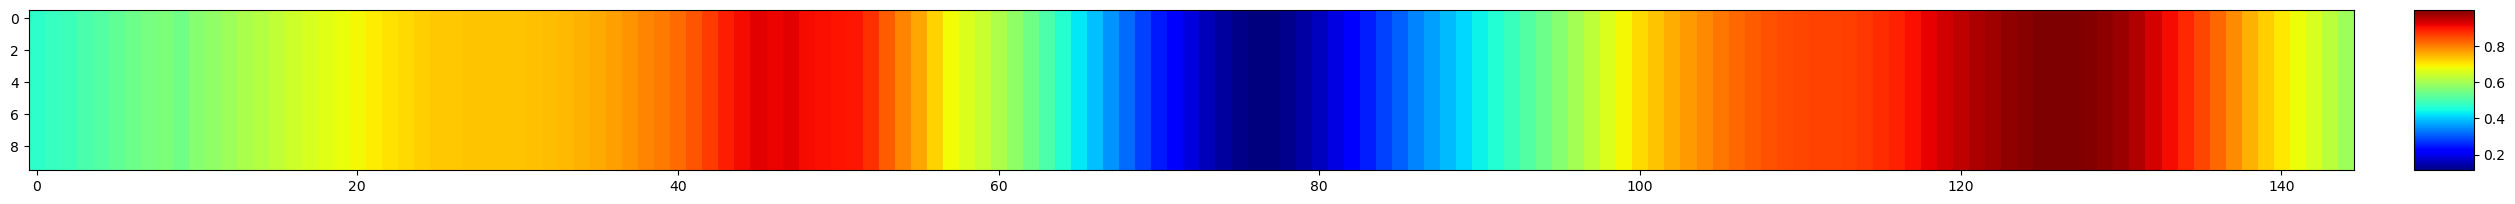

In [41]:
fig,ax = plt.subplots(figsize=(30,30))
arr = (bmag[:,6][::50],)*10
arrim = plt.imshow(arr,cmap='jet')



# Tim = ax.imshow(Tdat, cmap='OrRd')
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(arrim, cax=cax)

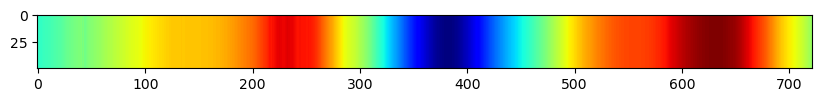

In [18]:
fig,ax = plt.subplots(figsize=(10,7))
arr = (bmag[:,6][::10],)*50
arrim = plt.imshow(arr,cmap='jet')


# Tim = ax.imshow(Tdat, cmap='OrRd')
# cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
# cbar = plt.colorbar(arrim, cax=cax)

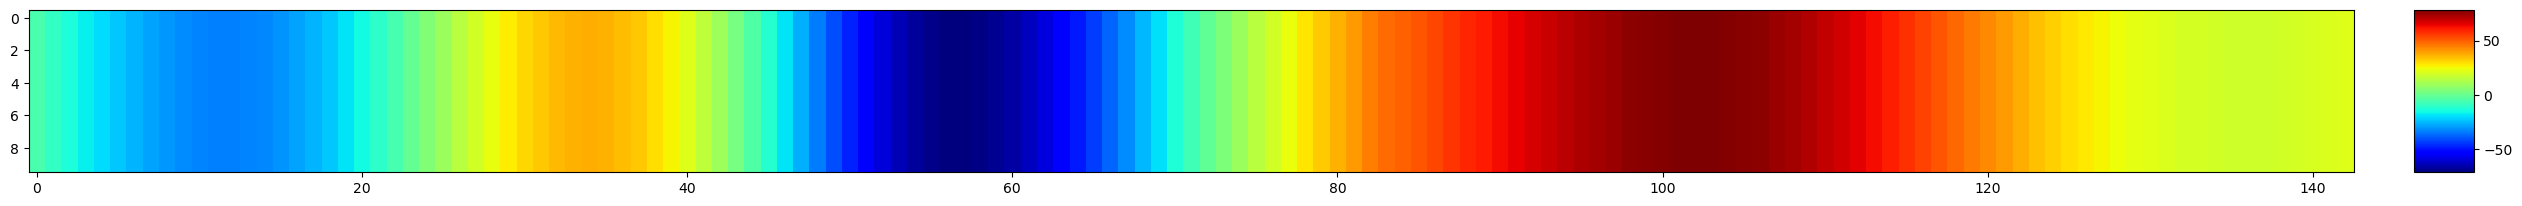

In [76]:
fig,ax = plt.subplots(figsize=(30,30))
arr = (br[:,4][::50],)*10
arrim = plt.imshow(arr,cmap='jet')



# Tim = ax.imshow(Tdat, cmap='OrRd')
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(arrim, cax=cax)

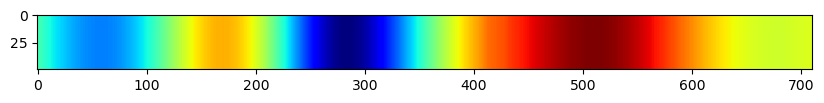

In [77]:
fig,ax = plt.subplots(figsize=(10,7))
arr = (br[:,4][::10],)*50
arrim = plt.imshow(arr,cmap='jet')


# Tim = ax.imshow(Tdat, cmap='OrRd')
# cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
# cbar = plt.colorbar(arrim, cax=cax)

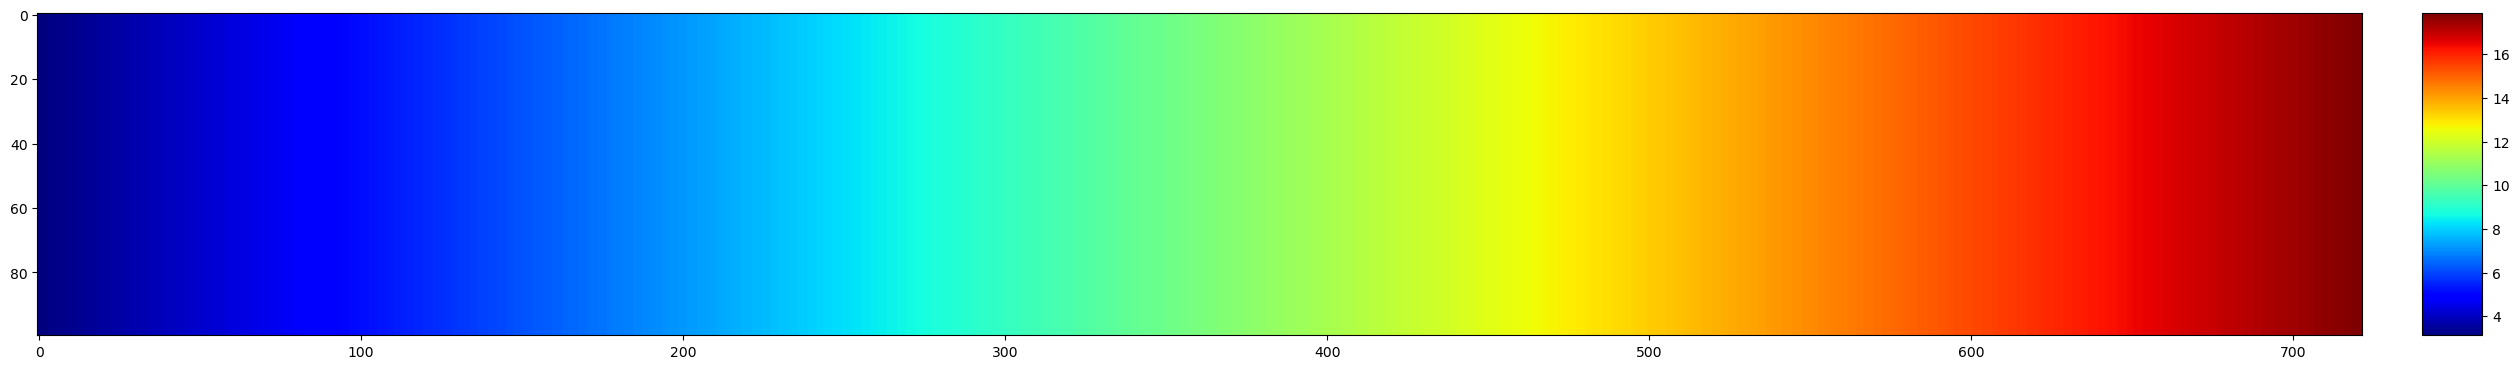

In [19]:
fig,ax = plt.subplots(figsize=(30,30))
arr = (bmag[:,1][::10],)*100
arrim = plt.imshow(arr,cmap='jet')


# Tim = ax.imshow(Tdat, cmap='OrRd')
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(arrim, cax=cax)

In [20]:
def diameter2angular(diameter):
    """
    Converts a crater's diameter from kilometers to degrees. 

    This equation is obtained by looking at many craters on JMars and
    roughly measuring the angular separation between the left and right
    edges. We then plot this against diameter in km (accessed from
    generate_crater_locations.m) and then finding the line of best fit,
    which is linear. Rough calculations here:
        https://docs.google.com/spreadsheets/d/1Ylr_Oowq_jV1KNXEGuSvXbWNbPZNGUQF1jjv2eTC7Jg/edit?usp=sharing
    """
    theta = 0.0186*diameter - 0.122
    return theta
def angular2diameter(theta):
    diameter = (theta+0.122)/0.0186
    return diameter